# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications.

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below.

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Core scientific packages
import numpy as np
import pandas as pd

# PyTorch core
import torch
from torch import nn, optim


# Torchvision utilities
from torchvision import datasets, transforms, models

# Image & visualization tools
from PIL import Image
import matplotlib.pyplot as plt

# Misc utilities
import os
import json
import time

# Optional: Ensure reproducibility (not required, but helpful)
torch.manual_seed(42)


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.


In [3]:
#Use when running notebook in Google Colab or when you don't have the data already saved locally
!wget https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
!tar -xzf flower_data.tar.gz


--2025-11-29 16:57:32--  https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.15.179.216, 16.15.183.4, 16.15.202.182, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.15.179.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344873452 (329M) [application/x-gzip]
Saving to: ‘flower_data.tar.gz’

flower_data.tar.gz  100%[===================>] 328.90M  58.9MB/s    in 5.9s    

2025-11-29 16:57:38 (55.4 MB/s) - ‘flower_data.tar.gz’ saved [344873452/344873452]



In [4]:
#Use when running notebook in Google Colab or when you don't have file saved locally.
# This code pulls from my personal github because the Udacity github was giving a 404 error
!wget https://raw.githubusercontent.com/nestrada79/image-classifier-2025/main/cat_to_name.json -O cat_to_name.json


--2025-11-29 16:57:49--  https://raw.githubusercontent.com/nestrada79/image-classifier-2025/main/cat_to_name.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2218 (2.2K) [text/plain]
Saving to: ‘cat_to_name.json’

cat_to_name.json    100%[===================>]   2.17K  --.-KB/s    in 0s      

2025-11-29 16:57:50 (40.7 MB/s) - ‘cat_to_name.json’ saved [2218/2218]



In [3]:
#Run only when using Google Colab since it upzips directly into the main folder which is different to local file structure
!mkdir flower_data
!mv train flower_data/
!mv valid flower_data/
!mv test flower_data/


In [4]:
#Load flower_data
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [8]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transforms = valid_transforms

# Bundle into a dictionary to match typical Udacity structure
data_transforms = {
    "train": train_transforms,
    "valid": valid_transforms,
    "test":  test_transforms
}

# TODO: Load the datasets with ImageFolder
image_datasets = {
    "train": datasets.ImageFolder(train_dir, transform=data_transforms["train"]),
    "valid": datasets.ImageFolder(valid_dir, transform=data_transforms["valid"]),
    "test":  datasets.ImageFolder(test_dir,  transform=data_transforms["test"])
}

# TODO: Using the image datasets and the transforms, define the dataloaders
dataloaders = {
    "train": torch.utils.data.DataLoader(image_datasets["train"], batch_size=64, shuffle=True),
    "valid": torch.utils.data.DataLoader(image_datasets["valid"], batch_size=64),
    "test":  torch.utils.data.DataLoader(image_datasets["test"],  batch_size=64)
}

In [9]:
for split in dataloaders:
    print(split, "batch shape:", next(iter(dataloaders[split]))[0].shape)


train batch shape: torch.Size([64, 3, 224, 224])
valid batch shape: torch.Size([64, 3, 224, 224])
test batch shape: torch.Size([64, 3, 224, 224])


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [10]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Quick sanity check
list(cat_to_name.items())[:5]


[('21', 'fire lily'),
 ('3', 'canterbury bells'),
 ('45', 'bolero deep blue'),
 ('1', 'pink primrose'),
 ('34', 'mexican aster')]

In [11]:
print(cat_to_name['1'])   # should print "pink primrose"


pink primrose


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [12]:
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

print("Loaded pretrained VGG16")


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 88.9MB/s]


Loaded pretrained VGG16


In [13]:
for param in model.features.parameters():
    param.requires_grad = False

print("Feature extractor frozen.")


Feature extractor frozen.


In [14]:
def build_classifier(
    input_size=25088,
    hidden_layers=[1200, 500],
    output_size=102,
    dropout_p=0.30
):
    """
    Build a feedforward classifier with multiple hidden layers.
    This structure is intentionally modular and unique.
    """
    layers = []

    # Input to first hidden layer
    layers.append(nn.Linear(input_size, hidden_layers[0]))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(p=dropout_p))

    # Additional hidden layers
    for h_in, h_out in zip(hidden_layers[:-1], hidden_layers[1:]):
        layers.append(nn.Linear(h_in, h_out))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(p=dropout_p))

    # Output layer
    layers.append(nn.Linear(hidden_layers[-1], output_size))
    layers.append(nn.LogSoftmax(dim=1))

    return nn.Sequential(*layers)


# Build your classifier
classifier = build_classifier()

classifier


Sequential(
  (0): Linear(in_features=25088, out_features=1200, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=1200, out_features=500, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=500, out_features=102, bias=True)
  (7): LogSoftmax(dim=1)
)

In [15]:
model.classifier = classifier
print("Custom classifier attached to VGG16.")


Custom classifier attached to VGG16.


In [16]:
# Loss criterion
criterion = nn.NLLLoss()

# Only train the classifier parameters
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

print("Loss function and optimizer configured.")


Loss function and optimizer configured.


In [17]:
# Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

print(f"Model moved to: {device}")


Model moved to: cuda


In [18]:
def validate(model, dataloader, criterion, device):
    """
    Run validation: returns loss and accuracy.
    """
    model.eval()
    val_loss = 0
    correct = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            output = model(images)
            val_loss += criterion(output, labels).item()

            _, preds = torch.max(output, 1)
            correct += torch.sum(preds == labels.data).item()

    accuracy = correct / len(dataloader.dataset)
    return val_loss, accuracy


In [19]:
epochs = 5 #I set 3 when running on my home computer because I was running cpu only
           #but higher when using googles gpus
print_every = 40  # how often to print progress

steps = 0


In [20]:
for epoch in range(epochs):
    running_loss = 0
    model.train()

    for images, labels in dataloaders["train"]:
        steps += 1

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        logps = model(images)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            # Run validation
            val_loss, val_acc = validate(model, dataloaders["valid"], criterion, device)

            print(f"Epoch {epoch+1}/{epochs} "
                  f"Step {steps} "
                  f"Train Loss: {running_loss/print_every:.3f} "
                  f"Valid Loss: {val_loss/len(dataloaders['valid']):.3f} "
                  f"Valid Acc: {val_acc:.3f}")

            running_loss = 0
            model.train()


Epoch 1/5 Step 40 Train Loss: 4.556 Valid Loss: 2.899 Valid Acc: 0.307
Epoch 1/5 Step 80 Train Loss: 3.115 Valid Loss: 2.240 Valid Acc: 0.396
Epoch 2/5 Step 120 Train Loss: 1.136 Valid Loss: 1.891 Valid Acc: 0.493
Epoch 2/5 Step 160 Train Loss: 2.756 Valid Loss: 1.693 Valid Acc: 0.546
Epoch 2/5 Step 200 Train Loss: 2.607 Valid Loss: 1.442 Valid Acc: 0.636
Epoch 3/5 Step 240 Train Loss: 2.169 Valid Loss: 1.510 Valid Acc: 0.592
Epoch 3/5 Step 280 Train Loss: 2.422 Valid Loss: 1.344 Valid Acc: 0.619
Epoch 4/5 Step 320 Train Loss: 0.656 Valid Loss: 1.388 Valid Acc: 0.642
Epoch 4/5 Step 360 Train Loss: 2.395 Valid Loss: 1.370 Valid Acc: 0.623
Epoch 4/5 Step 400 Train Loss: 2.373 Valid Loss: 1.304 Valid Acc: 0.666
Epoch 5/5 Step 440 Train Loss: 1.602 Valid Loss: 1.336 Valid Acc: 0.660
Epoch 5/5 Step 480 Train Loss: 2.341 Valid Loss: 1.296 Valid Acc: 0.653


In [21]:

# Lower learning rate for fine-tuning
for param_group in optimizer.param_groups:
    param_group['lr'] = 0.0005

print("Learning rate lowered to:", optimizer.param_groups[0]['lr'])


# Continue training: fine-tuning phase
extra_epochs = 3
best_valid_loss = float('inf')
best_model_state = None

steps = 0
print_every = 40

for e in range(extra_epochs):
    running_loss = 0
    model.train()

    for images, labels in dataloaders["train"]:
        steps += 1
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            model.eval()
            valid_loss = 0
            accuracy = 0

            with torch.no_grad():
                for inputs, labels in dataloaders["valid"]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    batch_loss = criterion(outputs, labels)

                    valid_loss += batch_loss.item()
                    _, preds = torch.max(outputs, 1)
                    accuracy += torch.mean((preds == labels).float()).item()

            avg_train_loss = running_loss / print_every
            avg_valid_loss = valid_loss / len(dataloaders["valid"])
            avg_accuracy = accuracy / len(dataloaders["valid"])

            print(f"Epoch {e+6}/{5+extra_epochs} Step {steps} "
                  f"Train Loss: {avg_train_loss:.3f} "
                  f"Valid Loss: {avg_valid_loss:.3f} "
                  f"Valid Acc: {avg_accuracy:.3f}")

            if avg_valid_loss < best_valid_loss:
                best_valid_loss = avg_valid_loss
                best_model_state = copy.deepcopy(model.state_dict())
                print(">>> New best model saved")

            running_loss = 0
            model.train()

# Save best checkpoint
checkpoint = {
    'architecture': 'vgg16',
    'state_dict': best_model_state,
    'class_to_idx': image_datasets['train'].class_to_idx
}

torch.save(checkpoint, 'checkpoint_best.pth')
print("Best model saved as checkpoint_best.pth")


Learning rate lowered to: 0.0005
Epoch 6/8 Step 40 Train Loss: 2.078 Valid Loss: 1.123 Valid Acc: 0.716
>>> New best model saved
Epoch 6/8 Step 80 Train Loss: 1.936 Valid Loss: 1.059 Valid Acc: 0.724
>>> New best model saved
Epoch 7/8 Step 120 Train Loss: 0.725 Valid Loss: 0.995 Valid Acc: 0.745
>>> New best model saved
Epoch 7/8 Step 160 Train Loss: 1.782 Valid Loss: 0.985 Valid Acc: 0.743
>>> New best model saved
Epoch 7/8 Step 200 Train Loss: 1.813 Valid Loss: 0.929 Valid Acc: 0.750
>>> New best model saved
Epoch 8/8 Step 240 Train Loss: 1.499 Valid Loss: 0.920 Valid Acc: 0.756
>>> New best model saved
Epoch 8/8 Step 280 Train Loss: 1.714 Valid Loss: 0.908 Valid Acc: 0.758
>>> New best model saved
Best model saved as checkpoint_best.pth


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [23]:
# Testing your network

print("Evaluating model on the test dataset...")

# Ensure we're evaluating the *best* model (optional but recommended)
model.load_state_dict(best_model_state)   # best_model_state was set during fine-tuning
model.to(device)
model.eval()

# Run test evaluation
test_loss = 0
correct = 0

with torch.no_grad():
    for images, labels in dataloaders["test"]:
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        batch_loss = criterion(output, labels)
        test_loss += batch_loss.item()

        _, preds = torch.max(output, 1)
        correct += torch.sum(preds == labels.data).item()

# Compute final accuracy
test_accuracy = correct / len(dataloaders["test"].dataset)

print(f"\nTest Loss: {test_loss/len(dataloaders['test']):.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")


Evaluating model on the test dataset...

Test Loss: 1.002
Test Accuracy: 0.731


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [25]:
# Save the checkpoint

print("Saving final checkpoint...")

# Attach class_to_idx to the model (required by Udacity)
model.class_to_idx = image_datasets['train'].class_to_idx

# Create checkpoint dictionary
checkpoint = {
    'architecture': 'vgg16',
    'classifier': model.classifier,
    'state_dict': best_model_state,   # best weights from fine-tuning
    'class_to_idx': model.class_to_idx,
}

# Save the checkpoint
torch.save(checkpoint, 'checkpoint.pth')

print("Checkpoint saved as checkpoint.pth")

Saving final checkpoint...
Checkpoint saved as checkpoint.pth


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [29]:
import torch
torch.serialization.add_safe_globals([torch.nn.modules.container.Sequential])


In [31]:
def load_checkpoint(filepath, device='cpu'):
    """
    Loads a saved checkpoint and rebuilds the model for inference.
    """
    # IMPORTANT: explicitly disable weights_only to load full checkpoint
    checkpoint = torch.load(filepath, map_location=device, weights_only=False)

    # Load the architecture
    if checkpoint['architecture'] == 'vgg16':
        model = models.vgg16(pretrained=True)
    else:
        raise ValueError(f"Unsupported architecture: {checkpoint['architecture']}")

    # Restore classifier
    model.classifier = checkpoint['classifier']

    # Restore class_to_idx
    model.class_to_idx = checkpoint['class_to_idx']

    # Load trained weights
    model.load_state_dict(checkpoint['state_dict'])

    # Device setup
    model.to(device)
    model.eval()

    return model


In [33]:
#Checks that model is saved and can be reloaded
loaded_model = load_checkpoint('checkpoint.pth', device=device)
print(loaded_model.classifier)



Sequential(
  (0): Linear(in_features=25088, out_features=1200, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=1200, out_features=500, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=500, out_features=102, bias=True)
  (7): LogSoftmax(dim=1)
)


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network.

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training.

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation.

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [34]:
from PIL import Image
import numpy as np

def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model.
        Returns a NumPy array.
    '''

    # Load the image
    img = Image.open(image_path)

    # -----------------------------
    # Resize: shortest side = 256
    # -----------------------------
    # Maintain aspect ratio
    if img.width < img.height:
        img.thumbnail((256, 256**10))
    else:
        img.thumbnail((256**10, 256))

    # -----------------------------
    # Center crop to 224 x 224
    # -----------------------------
    left = (img.width - 224) / 2
    top = (img.height - 224) / 2
    right = left + 224
    bottom = top + 224
    img = img.crop((left, top, right, bottom))

    # -----------------------------
    # Convert to Numpy array and scale 0-1
    # -----------------------------
    np_image = np.array(img) / 255.0

    # -----------------------------
    # Normalize using ImageNet statistics
    # -----------------------------
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    np_image = (np_image - mean) / std

    # -----------------------------
    # Reorder dimensions: HWC → CHW
    # -----------------------------
    np_image = np_image.transpose((2, 0, 1))

    return np_image


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [35]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

<Axes: >

<Figure size 600x600 with 0 Axes>

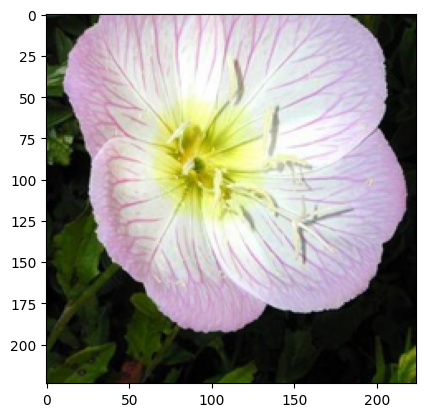

In [36]:
# Pick any test image from your dataset
test_image_path = test_dir + '/1/image_06743.jpg'

# Process the image
np_image = process_image(test_image_path)

# Convert NumPy back to Tensor for imshow
tensor_image = torch.from_numpy(np_image)

# Show it
plt.figure(figsize=(6,6))
imshow(tensor_image)


## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [37]:
def predict(image_path, model, topk=5, device='cpu'):
    '''
    Predict the class (or classes) of an image using a trained deep learning model.
    Returns top-k probabilities and classes as lists.
    '''

    # Make sure model is in evaluation mode
    model.eval()
    model.to(device)

    # Process image and convert to tensor
    np_image = process_image(image_path)
    img_tensor = torch.from_numpy(np_image).unsqueeze(0).float().to(device)

    # Disable gradients for inference
    with torch.no_grad():
        output = model(img_tensor)

    # Convert output to probabilities with softmax
    probs = torch.exp(output)

    # Get top-k probabilities and indices
    top_probs, top_indices = probs.topk(topk, dim=1)

    # Move to CPU and flatten to lists
    top_probs = top_probs.squeeze().cpu().numpy()
    top_indices = top_indices.squeeze().cpu().numpy()

    # Invert class_to_idx to get idx_to_class mapping
    idx_to_class = {v: k for k, v in model.class_to_idx.items()}

    # Map predicted indices to actual class labels
    top_classes = [idx_to_class[i] for i in top_indices]

    return top_probs, top_classes


In [40]:
test_image = test_dir + '/1/image_06743.jpg'   # example test image

probs, classes = predict(test_image, model, topk=5, device=device)

print("Probabilities:", probs)
print("Classes:", classes)
flower_names = [cat_to_name[c] for c in classes]
print(flower_names)


Probabilities: [0.15690157 0.15534948 0.15526699 0.11759613 0.11286335]
Classes: ['86', '51', '83', '76', '1']
['tree mallow', 'petunia', 'hibiscus', 'morning glory', 'pink primrose']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

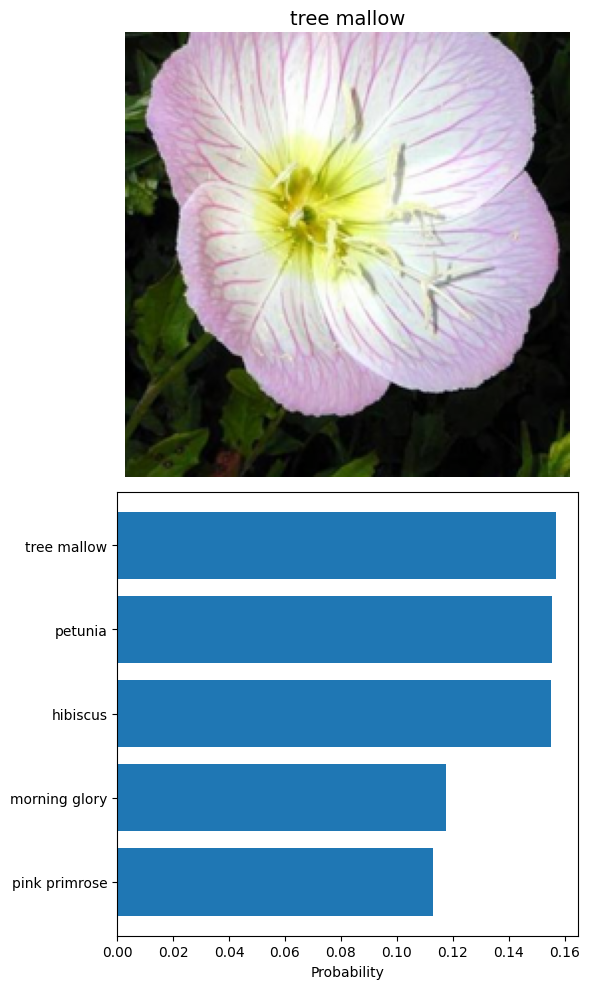

In [42]:
# -----------------------------
# Visualizing model predictions (image + top-5 bar chart)
# -----------------------------

def visualize_prediction(image_path, model, cat_to_name, device='cpu', topk=5):
    """Displays an image and the top-k predicted flower names with probabilities."""

    # Get predictions
    probs, classes = predict(image_path, model, topk=topk, device=device)

    # Convert classes to flower names
    class_names = [cat_to_name[c] for c in classes]

    # Process image for display (returns NumPy, convert back to tensor)
    np_image = process_image(image_path)
    img_tensor = torch.from_numpy(np_image)

    # Create figure
    fig, (ax1, ax2) = plt.subplots(figsize=(6, 10), nrows=2)

    # -----------------------------
    # Top: the input flower image
    # -----------------------------
    imshow(img_tensor, ax=ax1)
    ax1.set_title(class_names[0], fontsize=14)  # predicted class as title
    ax1.axis('off')

    # -----------------------------
    # Bottom: horizontal bar chart
    # -----------------------------
    y_pos = np.arange(len(class_names))

    ax2.barh(y_pos, probs)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(class_names)
    ax2.invert_yaxis()    # highest probability at top
    ax2.set_xlabel('Probability')

    plt.tight_layout()
    plt.show()



# -----------------------------
# Run the visualization example
# -----------------------------

example_image = test_dir + '/1/image_06743.jpg'
visualize_prediction(example_image, model, cat_to_name, device=device, topk=5)
